# Overview of data hierarchy:

This is an adaptation of the hierarchical bootstrap simulation code from https://github.com/soberlab/Hierarchical-Bootstrap-Paper to use to compare ripple abundance between 5XFAD and WT mice.

The original simulation code worked over 2 levels of data - neurons and trials. This data was stored in a 2D array where rows = higher level (neurons) and columns = repetitions w/in that level (trials). Eventually 2 populations of neurons are compared with each other. 

### original simulation dataset
  
#### hierarchy of the data

* neuron 1
    * trial 1
    * trial 2
    * trial n
* neuron 2
    * trial 1
    * trial 2
    * trial n
* neuron n
    * trial 1
    * trial 2
    * trial n

#### structure of the data

    [neuron 1 trial 1, neuron 1 trial 2, neuron 1 trial N;
     neuron 2 trial 1, neuron 2 trial 2, neuron 2 trial N;
     neuron N trial 1, neuron N trial 2, neuron N trial N]

The adapted bootstrapping code must work over 3 levels of data - animals, sessions, time periods. There are not an equal number of repetitions across any of the levels, so this data is stored in a matrix where each row is a single time period, with the animal and session specified. Eventually 2 populations of animals from different genotypes are compared with each other.

### my adapted dataset

#### hierarchy of the data

* genotype 1
    * animal 1
        * session 1
            * period 1
            * period n
        * session 2
            * period 1
            * period n
    * animal n
        * session 1
            * period 1
            * period n
        * session 2
            * period 1
            * period n
* genotype 2
    * animal 1
        * session 1
            * period 1
            * period n
        * session 2
            * period 1
            * period n
    * animal n
        * session 1
            * period 1
            * period n
        * session 2
            * period 1
            * period n
            
#### structure of the data

    [timeperiod 1, session 1, animal1;
     timeperiod 2, session 1, animal1;
     timeperiod N, session 1, animal1;
     timeperiod 1, session N, animal1;
     timeperiod N, session N, animal1;
     timeperiod 1, session 1, animalN;
     timeperiod N, session N, animalN]
    

# Defining functions for bootstrap analysis:

First we will import the relevant libraries that will be used

In [3]:
#Import relevant libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Two functions are defined below: A bootstrapping function over three levels of data and then a function that can compute the pboot value between two populations of bootstrapped samples.

In [4]:
def get_bootstrapped_sample(variable,levels,nboot=1000):
    '''
    This function performs a hierarchical bootstrap on the data present in 'variable'.
    
    This function assumes that the data in 'variable' is in the format of a dataframe where the
    input 'levels' indicates which columns contain the data from highest hierarchical level to the lowest.
    '''
    bootstats = np.zeros(nboot)
    
    #resample with replacement through all of the levels of the data
    for i in np.arange(nboot):
        temp = []
        vals_lev1 = np.unique(variable[levels[0]])
        num_levs = np.shape(vals_lev1)[0]
        rand_lev1 = np.random.choice(vals_lev1,int(num_levs))
        for j in rand_lev1:
            data_temp1 = variable[variable[levels[0]] == j]            #select subset of rows matching that first level
            data_subset_lev1 = np.unique(data_temp1[levels[1]])        #select column of data with next level information
            num_levs = np.shape(data_subset_lev1)[0]                   #gets the number of sessions for that animal
            rand_lev2 = np.random.choice(data_subset_lev1,int(num_levs))
            for k in rand_lev2:
                data_temp2 = data_temp1[data_temp1[levels[1]] == k]
                data_subset_lev2 = np.unique(data_temp2[levels[2]])
                num_levs = np.shape(data_subset_lev2)[0]                  
                rand_lev3 = np.random.choice(data_subset_lev2,int(num_levs))
                temp.extend(rand_lev3)

        #calculate the computation of interest (mean ripple rate in our case) here 
        bootstats[i] = np.nanmean(temp)

    return bootstats

In [59]:
def bootstrap_rec(data_input,rand_lev,levels,temp,n=0):
    
    if n == np.shape(levels)[0]-1:                                         #base condition - the lowest level
        temp.extend(rand_lev)                                              #append data at lowest level
        return temp
    else:
        for i in rand_lev:
            #get random sampling of data
            data_temp = data_input[data_input[levels[n]] == i]             #select subset of rows for first level
            data_subset = np.unique(data_temp[levels[n+1]])                #select column with info for next level
            num_subvals = np.shape(data_subset)[0]                         #get number of values within next level
            rand_lev_new = np.random.choice(data_subset,int(num_subvals))  #random sample next level with replacement
            
            print('----------------------------------------------------------------- \n'
                 'There are', num_subvals, levels[n+1], 'values for', levels[n], i, '\n'
                 'The random samples with replacement are ', rand_lev_new)

            bootstrap_rec(data_input,rand_lev_new,levels,temp,n+1)         #perform bootstrap at next level
        n = n+1                                                            #adjust counter for current level
    
    return temp

In [60]:
#inputs
variable = data_FAD;
levels = ['anID','sessID','riprates'];

#initialized variables
nboot = 1

bootstats = np.zeros(nboot)
#resample with replacement through all of the levels of the data
for i in np.arange(nboot):
    rand_lev = [1, 7, 13]
    temp = [];
    output = bootstrap_rec(variable,rand_lev,levels,temp)
    print(output)
    
    #calculate the computation of interest (mean ripple rate in our case) here 
    bootstats = np.nanmean(temp)
    

----------------------------------------------------------------- 
There are 3 sessID values for anID 1 
The random samples with replacement are  [15 15 18]
----------------------------------------------------------------- 
There are 1 riprates values for sessID 15 
The random samples with replacement are  [0.]
----------------------------------------------------------------- 
There are 1 riprates values for sessID 15 
The random samples with replacement are  [0.]
----------------------------------------------------------------- 
There are 15 riprates values for sessID 18 
The random samples with replacement are  [0.         0.1634254  0.15476283 0.11193821 0.15476283 0.11649581
 0.11065619 0.07449622 0.14089468 0.11193821 0.15417823 0.07449622
 0.1634254  0.07524171 0.09371632]
----------------------------------------------------------------- 
There are 2 sessID values for anID 7 
The random samples with replacement are  [20 20]
--------------------------------------------------------

In [5]:
def get_direct_prob(sample1, sample2):
    '''
    get_direct_prob Returns the direct probability of items from sample2 being
    greater than or equal to those from sample1.
       Sample1 and Sample2 are two bootstrapped samples and this function
       directly computes the probability of items from sample 2 being greater
       than or equal to those from sample1. Since the bootstrapped samples are
       themselves posterior distributions, this is a way of computing a
       Bayesian probability. The joint matrix can also be returned to compute
       directly upon.
    '''
    joint_low_val = min([min(sample1),min(sample2)])
    joint_high_val = max([max(sample1),max(sample2)])
    
    p_joint_matrix = np.zeros((100,100))
    p_axis = np.linspace(joint_low_val,joint_high_val,num=100)
    edge_shift = (p_axis[2] - p_axis[1])/2
    p_axis_edges = p_axis - edge_shift
    p_axis_edges = np.append(p_axis_edges, (joint_high_val + edge_shift))

    #Calculate probabilities using histcounts for edges.

    p_sample1 = np.histogram(sample1,bins=p_axis_edges)[0]/np.size(sample1)
    p_sample2 = np.histogram(sample2,bins=p_axis_edges)[0]/np.size(sample2)

    #Now, calculate the joint probability matrix:

    for i in np.arange(np.shape(p_joint_matrix)[0]):
        for j in np.arange(np.shape(p_joint_matrix)[1]):
            p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]
            
    #Normalize the joint probability matrix:
    p_joint_matrix = p_joint_matrix/np.sum(p_joint_matrix)
    
    #Get the volume of the joint probability matrix in the upper triangle:
    p_test = np.sum(np.triu(p_joint_matrix))
    
    return p_test, p_joint_matrix

# Data cleaning and analysis:

### Step 1 - Loading and splitting up the data by genotype

We want to compare all of the time periods recorded from X number of sessions from 9 animals in the two different 5XFAD and WT groups. First we will clean the data by splitting it up into the 5XFAD and WT groups.

First load in the data frame. Then select the 5XFAD and WT subsets of the original data frame based on their genotype ID.

In [6]:
df = pd.read_csv("ripRateTable5to2000s.csv")
data_FAD = df[df.genotypeID == 1] #1 indicates FAD 
data_WT = df[df.genotypeID == 2] #2 indicates WT
df.head()

,riprates,genotypeID,anID,sessID,periodID
0,0.0,2,8,1,1
1,0.0,2,8,1,2
2,0.0,2,8,1,3
3,0.0,2,8,1,4
4,0.0,2,8,1,5


### Step 2 - Calculating traditional statistics

Get the traditional statistics for the data using all of the samples

In [7]:
#Get t-statistic p-value for traditional calculation:
ttest_results = stats.ranksums(data_FAD.riprates,data_WT.riprates)[1]
#Get SEMs for the same:
ttest_sem_results_FAD = np.std(data_FAD.riprates)/np.sqrt(np.size(data_FAD.riprates))
ttest_sem_results_WT = np.std(data_WT.riprates)/np.sqrt(np.size(data_WT.riprates))

print("Traditional rank sum p-value:", ttest_results)

Traditional rank sum p-value: 1.917061145057577e-16


### Step 3 - Calculating summarized statistics

Get the summarized statistics for the data by getting an average ripple rate for each animal across all sessions and time periods

In [8]:
#Get the summarized values for each animal for each genotype:
iden_an_FAD = np.unique(data_FAD.anID)
mean_an_FAD = [] #initialize data struct
for i in iden_an_FAD:
    an_data = data_FAD[data_FAD.anID == i]
    an_mean = np.nanmean(an_data.riprates) #get average ripple rate for each animal across sessions/timeperiods
    mean_an_FAD = np.append(mean_an_FAD, an_mean)
    
iden_an_WT = np.unique(data_WT.anID)
mean_an_WT = [] #initialize data struct
for i in iden_an_WT:
    an_data = data_WT[data_WT.anID == i]
    an_mean = np.nanmean(an_data.riprates) #get average ripple rate for each animal across sessions/timeperiods
    mean_an_WT = np.append(mean_an_WT, an_mean)
    
#Get t-statistic p-value for summarized calculation:
sum_results = stats.ranksums(mean_an_FAD,mean_an_WT)[1]
#Get SEMs for the same:
sum_sem_results_FAD = np.std(mean_an_FAD)/np.sqrt(np.size(mean_an_FAD))
sum_sem_results_WT = np.std(mean_an_WT)/np.sqrt(np.size(mean_an_WT))

print("5XFAD means are", mean_an_FAD, "\n WT means are", mean_an_WT)
print("Summarized statistics rank sum p-value:", sum_results)

5XFAD means are [0.00516463 0.00104937 0.00650678 0.04743681 0.03454172] 
 WT means are [0.14861612 0.01472387 0.12741749 0.03519837]
Summarized statistics rank sum p-value: 0.0864107329737


### Step 4 - Calculating the bootstrap statistics

Now we will get the bootstrapped samples and probability for the hierarchical bootstrap statistics

In [9]:
n_runs = 1000
for i in np.arange(n_runs):
    #define the levels we will use (ordered from highest to lowest)
    levels = ['anID','sessID','periodID'];
    #calculate bootstrapped samples:
    bootstats_FAD = get_bootstrapped_sample(data_FAD, levels)
    bootstats_WT = get_bootstrapped_sample(data_WT, levels)
    #Calculate probability of bootstats2 >= bootstats1:
    boostrap_results = get_direct_prob(bootstats_FAD,bootstats_WT)[0]
    #Get SEM from bootstrapped samples:
    boostrap_sem_results_FAD = np.std(bootstats_FAD)
    boostrap_sem_results_WT = np.std(bootstats_WT)
        
    print("Run {} completed".format(i))
    

KeyboardInterrupt: 

## Run the Experiment:

In [22]:
#This code may take a while to run. For speed, the results were saved after running once and subsequently loaded
#into the cells below:
results = get_simulated_results(neurons)
sem_results = results[1]
results = results[0]

#Get the proportion of significant differences:
prop_of_sig_results = np.zeros(3)
prop_of_sig_results[0] = np.sum(results[:,0]<0.05)/np.size(results[:,0])
prop_of_sig_results[1] = np.sum(results[:,1]<0.05)/np.size(results[:,1])
prop_of_sig_results[2] = np.sum((results[:,2]<0.05) | (results[:,2]>0.95))/np.size(results[:,0])

#Save the measures of the SEM:
sem_summaries = np.zeros(6)
sem_summaries[0] = np.mean(sem_results[:,:2])
sem_summaries[1] = np.std(sem_results[:,:2])
sem_summaries[2] = np.mean(sem_results[:,2:4])
sem_summaries[3] = np.std(sem_results[:,2:4])
sem_summaries[4] = np.mean(sem_results[:,4:])
sem_summaries[5] = np.std(sem_results[:,4:])

#We save and load the results since the simulations take over 24 hours to run for 10000 runs
np.savetxt('sig_results_fig_1.csv',prop_of_sig_results,delimiter=',')
np.savetxt('sem_summaries_fig_1.csv',sem_summaries,delimiter=',')
np.savetxt('pvalues_full_fig_1.csv',results,delimiter=',')

KeyboardInterrupt: 

In [23]:
#Load the saved values into the corresponding variable names:
prop_of_sig_results = np.loadtxt('sig_results_fig_1.csv',delimiter=',')
sem_summaries = np.loadtxt('sem_summaries_fig_1.csv',delimiter = ',')
results = np.loadtxt('pvalues_full_fig_1.csv',delimiter=',')

In [24]:
#Include alpha = 5% for bootstrapping procedure to proportion of significant results:
prop_of_sig_results = np.append(prop_of_sig_results,np.sum((results[:,2]<0.025) | (results[:,2]>0.975))/np.size(results[:,0]))

In [25]:
#In order to get the error bars on the proportion of significant results, we can again bootstrap:
prop_of_sig_results_error_bars = np.zeros(np.shape(prop_of_sig_results))
prop_of_sig_results_diff_5 = np.zeros(np.shape(prop_of_sig_results))

nboot = 10000
bootstats1 = np.zeros(nboot)
bootstats2 = np.zeros(nboot)
bootstats3 = np.zeros(nboot)
bootstats4 = np.zeros(nboot)
np.random.seed(1234) #For reproducibility since this is used for stats tests

for n in np.arange(nboot):
    num_lev = np.shape(results)[0]
    rand_lev = np.random.choice(num_lev,num_lev)
    temp = results[rand_lev,:]
    
    bootstats1[n] = np.sum(temp[:,0]<0.05)/np.size(temp[:,0])
    bootstats2[n] = np.sum(temp[:,1]<0.05)/np.size(temp[:,1])
    bootstats3[n] = np.sum((temp[:,2]<0.05) | (temp[:,2]>0.95))/np.size(temp[:,2])
    bootstats4[n] = np.sum((temp[:,2]<0.025) | (temp[:,2]>0.975))/np.size(temp[:,2])

prop_of_sig_results_error_bars[0] = np.std(bootstats1)
prop_of_sig_results_error_bars[1] = np.std(bootstats2)
prop_of_sig_results_error_bars[2] = np.std(bootstats3)
prop_of_sig_results_error_bars[3] = np.std(bootstats4)

In [26]:
#We can then compute if the distributions are significantly different from the expected 5% false positive rate:
prop_of_sig_results_diff_5[0] = np.sum(bootstats1 >= 0.05)/np.size(bootstats1)
prop_of_sig_results_diff_5[1] = np.sum(bootstats2 >= 0.05)/np.size(bootstats2)
prop_of_sig_results_diff_5[2] = np.sum(bootstats3 >= 0.05)/np.size(bootstats3)
prop_of_sig_results_diff_5[3] = np.sum(bootstats4 >= 0.05)/np.size(bootstats4)

prop_of_sig_results_diff_5

array([0.2623, 0.4161, 0.    , 0.    ])

As shown above, while the Traditional and Summarized methods are not different from 5%, the bootstrap is for both alpha = 5% and even alpha = 10%.

<IPython.core.display.Javascript object>


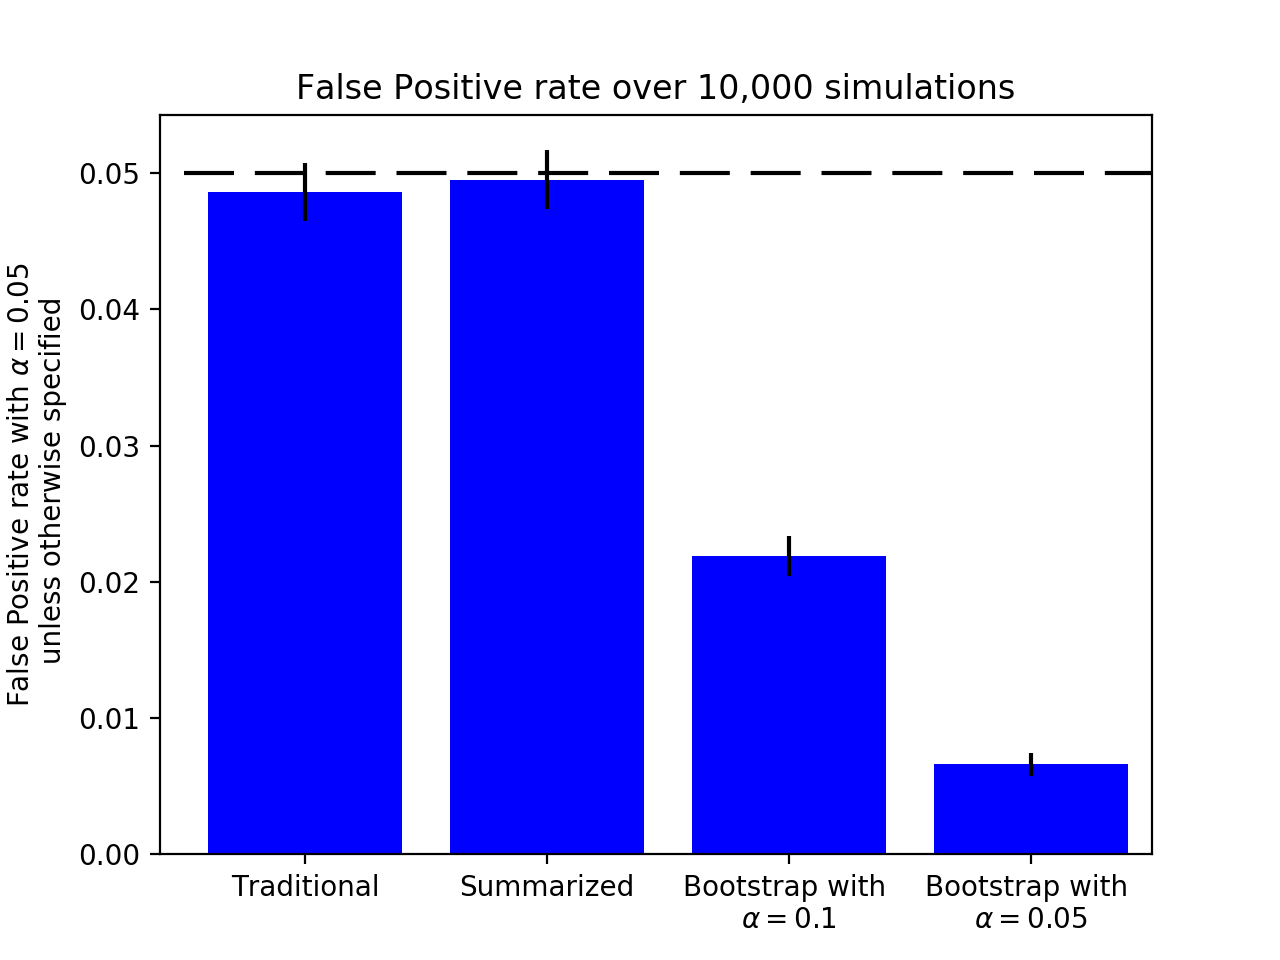

Text(0.5, 1.0, 'False Positive rate over 10,000 simulations')

In [27]:
#Figure 3a in paper:

%matplotlib notebook
index = np.arange(len(prop_of_sig_results))
alpha = 0.05*np.ones(np.shape(index))
plt.bar(index,prop_of_sig_results,color='b',yerr=prop_of_sig_results_error_bars)
plt.plot([-0.5, 3.5],[0.05, 0.05],color='k',dashes=[12,5],label = '5% level')
labels = ['Traditional', 'Summarized','Bootstrap with \n' r'$\alpha = 0.1$', 'Bootstrap with \n' r'$\alpha = 0.05$']
plt.xticks(index,labels)
plt.xlim([-0.6,3.5])
plt.ylabel('False Positive rate with 'r'$\alpha = 0.05$' '\n unless otherwise specified')
plt.title('False Positive rate over 10,000 simulations')

<IPython.core.display.Javascript object>


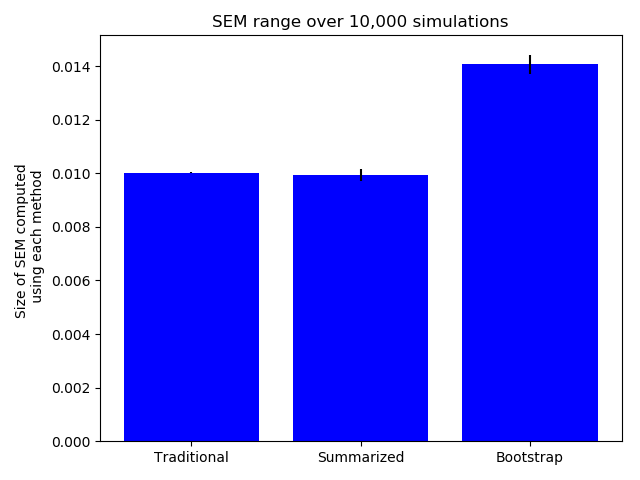

In [12]:
#Figure 3b in paper:

index = np.arange(3)
plt.bar(index,sem_summaries[[0,2,4]],color='b',yerr=sem_summaries[[1,3,5]])
labels = ['Traditional', 'Summarized', 'Bootstrap']
plt.xticks(index,labels)
plt.ylabel('Size of SEM computed \n using each method')
plt.title('SEM range over 10,000 simulations')
plt.tight_layout()

# Fig 2 - conservative bias when data points are not independent

In the above example, since the variance was the same between levels, all the datapoints were still independent in spite of the hierarchical structure. Here, we will make the points non-independent by adding Gaussian noise to the mean firing rates of each neuron without changing the firing rate across trials. We will also test the effect of varying the number of trials on the false positive rate.

In [ ]:
#This simulation too takes a while to run. Hence, the same strategy as before has been deployed:
np.random.seed(1234) #Seed for reproducibility.
firing_rate = 5
num_trials = [10, 30, 100, 300, 1000, 3000]
num_runs = len(num_trials)

prop_of_sig_results = np.zeros((num_runs,3))
sem_summaries = np.zeros((num_runs,6))
prop_of_sig_results_error_bars = np.zeros(np.shape(prop_of_sig_results))
prop_of_sig_results_diff_5 = np.zeros(np.shape(prop_of_sig_results))

run = 0

for trials in num_trials:
    neurons = np.zeros((1000,trials))
    num_lev1 = np.shape(neurons)[0]
    num_lev2 = np.shape(neurons)[1]
    for i in np.arange(num_lev1):
        f_rate = firing_rate + 3*np.random.normal(0,1)
        if f_rate < 0:
            f_rate = 0.01
        neurons[i,:] = np.random.poisson(lam=f_rate,size=(1,trials))
            
    results, sem_results = get_simulated_results(neurons)
    
    prop_of_sig_results[run,0] = np.sum(results[:,0]<0.05)/np.size(results[:,0])
    prop_of_sig_results[run,1] = np.sum(results[:,1]<0.05)/np.size(results[:,1])
    prop_of_sig_results[run,2] = np.sum((results[:,2]<0.025) | (results[:,2]>0.975))/np.size(results[:,0])
    
    sem_summaries[run,0] = np.mean(sem_results[:,:2])
    sem_summaries[run,1] = np.std(sem_results[:,:2])
    sem_summaries[run,2] = np.mean(sem_results[:,2:4])
    sem_summaries[run,3] = np.std(sem_results[:,2:4])
    sem_summaries[run,4] = np.mean(sem_results[:,4:])
    sem_summaries[run,5] = np.std(sem_results[:,4:])
    
    nboot = 10000
    bootstats1 = np.zeros(nboot)
    bootstats2 = np.zeros(nboot)
    bootstats3 = np.zeros(nboot)

    for n in np.arange(nboot):
        num_lev = np.shape(results)[0]
        rand_lev = np.random.choice(num_lev,num_lev)
        temp = results[rand_lev,:]

        bootstats1[n] = np.sum(temp[:,0]<0.05)/np.size(temp[:,0])
        bootstats2[n] = np.sum(temp[:,1]<0.05)/np.size(temp[:,1])
        bootstats3[n] = np.sum((temp[:,2]<0.025) | (temp[:,2]>0.975))/np.size(temp[:,2])

    prop_of_sig_results_error_bars[run,0] = np.std(bootstats1)
    prop_of_sig_results_error_bars[run,1] = np.std(bootstats2)
    prop_of_sig_results_error_bars[run,2] = np.std(bootstats3)
    
    prop_of_sig_results_diff_5[run,0] = np.sum(bootstats1 >= 0.05)/np.size(bootstats1)
    prop_of_sig_results_diff_5[run,1] = np.sum(bootstats2 >= 0.05)/np.size(bootstats2)
    prop_of_sig_results_diff_5[run,2] = np.sum(bootstats3 >= 0.05)/np.size(bootstats3)
    
    print("Finished simulations for {} number of trials".format(trials))
    
    run = run+1

In [ ]:
#We save and load the results since the simulations take over 24 hours to run for 10000 runs
np.savetxt('sig_results_fig_2.csv',prop_of_sig_results,delimiter=',')
np.savetxt('sem_summaries_fig_2.csv',sem_summaries,delimiter=',')
np.savetxt('sig_error_bars_fig_2.csv',prop_of_sig_results_error_bars,delimiter=',')
np.savetxt('sig_diff_5_fig_2.csv',prop_of_sig_results_diff_5,delimiter=',')

In [13]:
#Produce figures:
prop_of_sig_results = np.loadtxt('sig_results_fig_2.csv',delimiter=',')
sem_summaries = np.loadtxt('sem_summaries_fig_2.csv',delimiter = ',')
prop_of_sig_results_error_bars = np.loadtxt('sig_error_bars_fig_2.csv',delimiter=',')

<IPython.core.display.Javascript object>


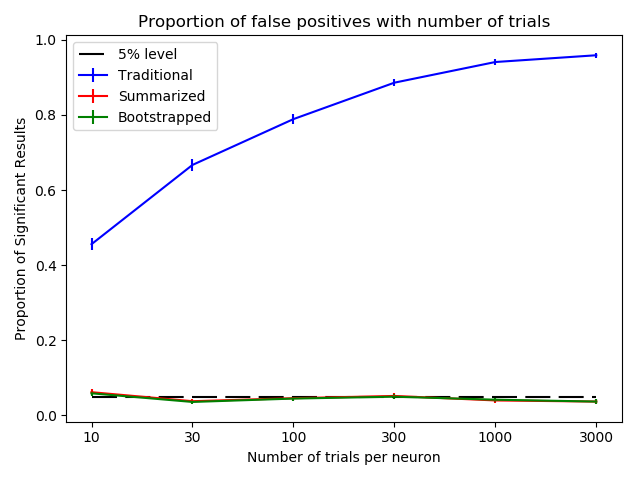

In [16]:
#Figure 2a in paper:

num_trials = [10, 30, 100, 300, 1000, 3000]
num_groups = len(num_trials)

index = np.arange(num_groups)
alpha = 0.05*np.ones(np.shape(index))
bar_width = 0.1

plt.errorbar(index, prop_of_sig_results[:,0],
        yerr=prop_of_sig_results_error_bars[:,0], color='b', label='Traditional')

plt.errorbar(index , prop_of_sig_results[:,1],
        yerr=prop_of_sig_results_error_bars[:,1], color='r', label='Summarized')

plt.errorbar(index, prop_of_sig_results[:,2],
        yerr=prop_of_sig_results_error_bars[:,2], color='g', label='Bootstrapped')

plt.plot(index,alpha,color='k',dashes=[12,4],label = '5% level')

plt.xlabel('Number of trials per neuron')
plt.ylabel('Proportion of Significant Results')
plt.title('Proportion of false positives with number of trials')
plt.xticks(index,num_trials)
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


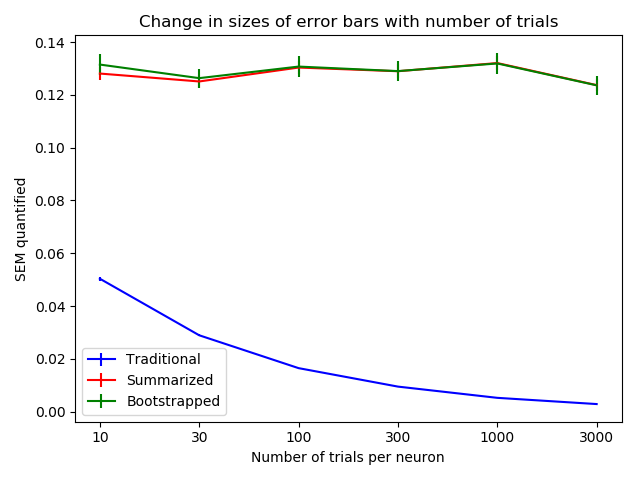

In [17]:
#Figure 2b in paper:

index = np.arange(num_groups)

plt.errorbar(index, sem_summaries[:,0], yerr=sem_summaries[:,1],
        color='b', label='Traditional')

plt.errorbar(index, sem_summaries[:,2], yerr=sem_summaries[:,3],
        color='r', label='Summarized')

plt.errorbar(index, sem_summaries[:,4], yerr=sem_summaries[:,5],
        color='g', label='Bootstrapped')

plt.xlabel('Number of trials per neuron')
plt.ylabel('SEM quantified')
plt.title('Change in sizes of error bars with number of trials')
plt.xticks(index, num_trials)
plt.legend()

plt.tight_layout()

## Fig 4 - the effects on statistical power:

Power is defined as 1 - the false negative rate beta. Therefore, in order to compute power, we need to have a situation in which there is a statistical difference between groups. And we need to compute the fraction of times that difference is not detected by the various methods.

In order to do this, let us once again use our example of neuron firing. Let us now have two groups of neurons, one with a mean firing rate of 5Hz and the other with a mean firing rate of 5 + Delta Hz where Delta is a measure of the effect size and Delta varys as 0, 1.5, 3, 4.5 Hz respectively. Additionally, let us study the effect of varying the number of neurons in each group keeping the number of trials constant.

In [18]:
def get_simulated_results(firing_rate1,firing_rate2,neurons):
    #Set simulation run parameters here:
    n_runs = 1000
    
    low_data = np.zeros((neurons,100))
    high_data = np.zeros((neurons,100))
    num_lev1 = np.shape(low_data)[0]
    num_lev2 = np.shape(low_data)[1]
    
    #Define variables in which results will be saved:
    results = np.zeros((n_runs,3)) #3 columns for p-values from traditional, summarized and bootstrapped
    sem_results = np.zeros((n_runs,6)) #6 columns for SEMs similarly since each has SEM for low and high rates
    
    #Repeat the experiment for n_runs times:
    for i in np.arange(n_runs):
        for n in np.arange(num_lev1):
            f_rate1 = firing_rate1 + 3*np.random.normal(0,1)
            if f_rate1 < 0:
                f_rate1 = 0.01
            low_data[n,:] = np.random.poisson(lam=f_rate1,size=(1,100))
            f_rate2 = firing_rate2 + 3*np.random.normal(0,1)
            if f_rate2 < 0:
                f_rate2 = 0.01
            high_data[n,:] = np.random.poisson(lam=f_rate2,size=(1,100))
        
        #Get t-statistic p-value for traditional calculation:
        results[i,0] = stats.ttest_ind(np.ravel(low_data),np.ravel(high_data))[1]
        #Get SEMs for the same:
        sem_results[i,0] = np.std(low_data)/np.sqrt(np.size(low_data))
        sem_results[i,1] = np.std(high_data)/np.sqrt(np.size(high_data))
        
        low_means = np.mean(low_data,1)
        high_means = np.mean(high_data,1)
        
        #Get t-statistic p-value for summarized calculation:
        results[i,1] = stats.ttest_ind(low_means,high_means)[1]
        #Get SEMs for the same:
        sem_results[i,2] = np.std(low_means)/np.sqrt(np.size(low_means))
        sem_results[i,3] = np.std(high_means)/np.sqrt(np.size(high_means))
        
        #Now calculate bootstrapped samples:
        bootstats1 = get_bootstrapped_sample(low_data)
        bootstats2 = get_bootstrapped_sample(high_data)
        
        #Calculate probability of bootstats2 >= bootstats1:
        results[i,2] = get_direct_prob(bootstats1,bootstats2)[0]
        #Get SEM from bootstrapped samples:
        sem_results[i,4] = np.std(bootstats1)
        sem_results[i,5] = np.std(bootstats2)
        
        print("Run {} completed".format(i))
        
    return results, sem_results

In [ ]:
#As before, simulation takes a long time to run:
np.random.seed(1234) #Seed for reproducibility.
firing_rate1 = 5
firing_rate2 = [5, 6.5, 8, 9.5] #The first run will give the false positive rate
num_neurons = np.arange(16) + 1
num_runs = len(num_neurons)
num_runs2 = len(firing_rate2)

prop_of_sig_results = np.zeros((num_runs,3,num_runs2))
sem_summaries = np.zeros((num_runs,6))
prop_of_sig_results_error_bars = np.zeros(np.shape(prop_of_sig_results))

run = 0
run2 = 0

for firing_rate in firing_rate2:
    for neurons in num_neurons:

        results, sem_results = get_simulated_results(firing_rate1, firing_rate, neurons)

        prop_of_sig_results[run,0,run2] = np.sum(results[:,0]<0.05)/np.size(results[:,0])
        prop_of_sig_results[run,1,run2] = np.sum(results[:,1]<0.05)/np.size(results[:,1])
        prop_of_sig_results[run,2,run2] = np.sum((results[:,2]<0.025) | (results[:,2]>0.975))/np.size(results[:,0])

        nboot = 10000
        bootstats1 = np.zeros(nboot)
        bootstats2 = np.zeros(nboot)
        bootstats3 = np.zeros(nboot)

        for n in np.arange(nboot):
            num_lev = np.shape(results)[0]
            rand_lev = np.random.choice(num_lev,num_lev)
            temp = results[rand_lev,:]

            bootstats1[n] = np.sum(temp[:,0]<0.05)/np.size(temp[:,0])
            bootstats2[n] = np.sum(temp[:,1]<0.05)/np.size(temp[:,1])
            bootstats3[n] = np.sum((temp[:,2]<0.025) | (temp[:,2]>0.975))/np.size(temp[:,2])

        prop_of_sig_results_error_bars[run,0,run2] = np.std(bootstats1)
        prop_of_sig_results_error_bars[run,1,run2] = np.std(bootstats2)
        prop_of_sig_results_error_bars[run,2,run2] = np.std(bootstats3)

        print("Finished simulations for {} number of neurons".format(neurons))

        run = run+1
        
    print("Finished simulations for {} firing rate".format(firing_rate))
    run2 = run2+1
    run = 0

In [ ]:
#In order to save, we need to convert the 3-D arrays to 2-D and reliably back:
np.savetxt('sig_results_power.csv', prop_of_sig_results.reshape(num_runs*num_runs2,3),delimiter=',')
np.savetxt('sig_results_error_bars_power.csv',prop_of_sig_results_error_bars.reshape(num_runs*num_runs2,3),delimiter=',')

In [19]:
#If they need to be loaded back, they will need to reshaped like so:
firing_rate1 = 5
firing_rate2 = [5, 6.5, 8, 9.5] #The first run will give the false positive rate
num_neurons = np.arange(16) + 1
num_runs = len(num_neurons)
num_runs2 = len(firing_rate2)
prop_of_sig_results = np.loadtxt('sig_results_power.csv',delimiter=',').reshape(num_runs,3,num_runs2)
prop_of_sig_results_error_bars = np.loadtxt('sig_results_error_bars_power.csv',delimiter=',').reshape(num_runs,3,num_runs2)

<IPython.core.display.Javascript object>


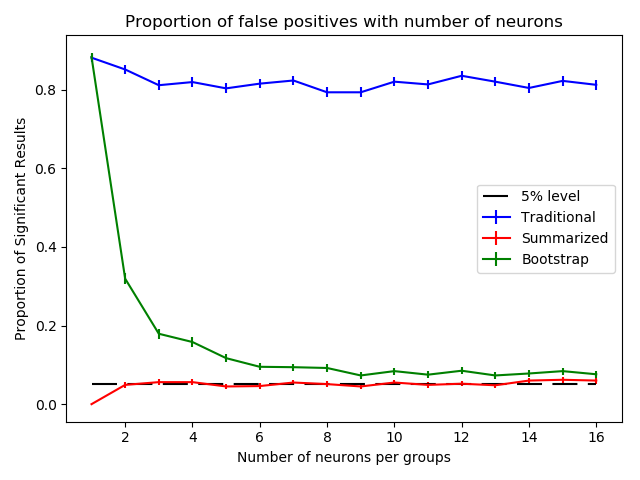

In [20]:
#Figure 4a in paper:

index = np.arange(16) + 1
#index = index[1:]
alpha = 0.05*np.ones(np.shape(index))

plt.errorbar(index,prop_of_sig_results[:,0,0],yerr = prop_of_sig_results_error_bars[:,0,0],
         color = 'b', label = 'Traditional')

plt.errorbar(index,prop_of_sig_results[:,1,0],yerr = prop_of_sig_results_error_bars[:,1,0],
         color = 'r', label = 'Summarized')

plt.errorbar(index,prop_of_sig_results[:,2,0],yerr = prop_of_sig_results_error_bars[:,2,0],
         color = 'g', label = 'Bootstrap')

plt.plot(index,alpha,color='k',dashes=[12,5],label = '5% level')

plt.xlabel('Number of neurons per groups')
plt.ylabel('Proportion of Significant Results')
plt.title('Proportion of false positives with number of neurons')
plt.legend()

plt.tight_layout()


<IPython.core.display.Javascript object>


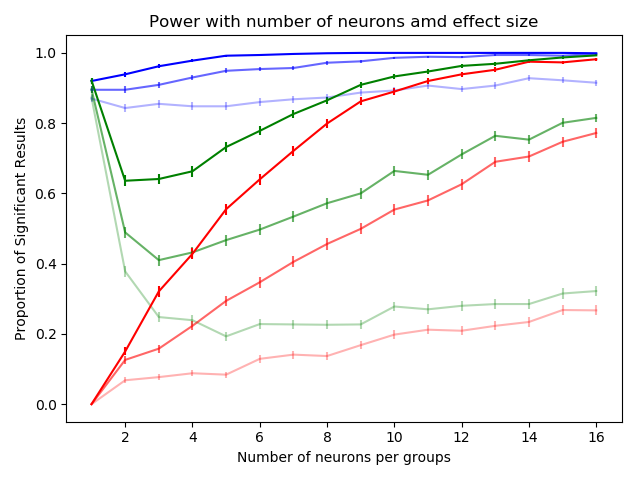

In [21]:
#Figure 4b in the paper:

alpha = 0.05*np.ones(np.shape(index))
opacity = [0.3,0.6,1]

plt.errorbar(index,prop_of_sig_results[:,0,1],yerr = prop_of_sig_results_error_bars[:,0,1],
         alpha = opacity[0], color = 'b', label = 'Traditional')

plt.errorbar(index,prop_of_sig_results[:,1,1],yerr = prop_of_sig_results_error_bars[:,1,1],
         alpha = opacity[0], color = 'r', label = 'Summarized')

plt.errorbar(index,prop_of_sig_results[:,2,1],yerr = prop_of_sig_results_error_bars[:,2,1],
         alpha = opacity[0], color = 'g', label = 'Bootstrap')

plt.errorbar(index,prop_of_sig_results[:,0,2],yerr = prop_of_sig_results_error_bars[:,0,2],
         alpha = opacity[1], color = 'b', label = 'Traditional')

plt.errorbar(index,prop_of_sig_results[:,1,2],yerr = prop_of_sig_results_error_bars[:,1,2],
         alpha = opacity[1], color = 'r', label = 'Summarized')

plt.errorbar(index,prop_of_sig_results[:,2,2],yerr = prop_of_sig_results_error_bars[:,2,2],
         alpha = opacity[1], color = 'g', label = 'Bootstrap')

plt.errorbar(index,prop_of_sig_results[:,0,3],yerr = prop_of_sig_results_error_bars[:,0,3],
         alpha = opacity[2], color = 'b', label = 'Traditional')

plt.errorbar(index,prop_of_sig_results[:,1,3],yerr = prop_of_sig_results_error_bars[:,1,3],
         alpha = opacity[2], color = 'r', label = 'Summarized')

plt.errorbar(index,prop_of_sig_results[:,2,3],yerr = prop_of_sig_results_error_bars[:,2,3],
         alpha = opacity[2], color = 'g', label = 'Bootstrap')

plt.xlabel('Number of neurons per groups')
plt.ylabel('Proportion of Significant Results')
plt.title('Power with number of neurons amd effect size')


plt.tight_layout()